# OCR engine comparison

<img src="https://media.arxiv-vanity.com/render-output/6158804/images/fig_2_no_trademarks.png" alt="text to images" width="600" height="600">

In [2]:
import pandas as pd
import numpy as np
import random

from glob import glob
# from tqdm.notebook import tqdm
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import cv2

plt.style.use('ggplot')

# Outline
1. Take a look at the data
2. Extract text from images:
    - pytesseract
    - easyocr
    - keras_ocr
3. Run on a few examples and compare the results

## About the data
TextOCR requires models to perform text-recognition on arbitrary shaped scene-text present on natural images. TextOCR provides ~1M high quality word annotations on TextVQA images allowing application of end-to-end reasoning on downstream tasks such as visual question answering or image captioning.

- 28,134 natural images from TextVQA
- 903,069 annotated scene-text words
- 32 words per image on average

In [3]:
annot = pd.read_parquet('train_val_images/annot.parquet')
imgs = pd.read_parquet('train_val_images/img.parquet')
img_fns = glob('train_val_images/train_images/*')

In [4]:
annot.head(5)

,id,image_id,bbox,utf8_string,points,area
0,a4ea732cd3d5948a_1,a4ea732cd3d5948a,"[525.83, 3.4, 197.64, 33.94]",Performance,"[525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...",6707.90
1,a4ea732cd3d5948a_2,a4ea732cd3d5948a,"[534.67, 64.68, 91.22, 38.19]",Sport,"[535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...",3483.69
2,a4ea732cd3d5948a_3,a4ea732cd3d5948a,"[626.95, 63.62, 96.52, 31.82]",Watch,"[626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...",3071.27
3,a4ea732cd3d5948a_4,a4ea732cd3d5948a,"[577.4, 141.87, 147.13, 43.1]",...period.,"[580.02, 143.61, 724.53, 141.87, 723.66, 184.9...",6341.30
4,a4ea732cd3d5948a_5,a4ea732cd3d5948a,"[391.03, 163.9, 60.82, 38.65]",.,"[395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...",2350.69


# Plot Example Images

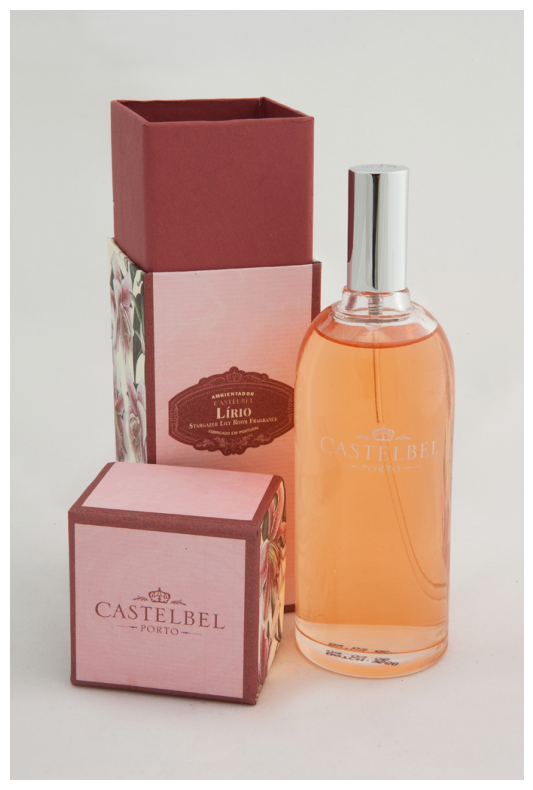

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[100]))
ax.axis('off')
plt.show()

In [6]:
image_id = img_fns[100].split('/')[-1].split('\\')[-1].split('.')[0]
annot[annot["image_id"] == image_id]

,id,image_id,bbox,utf8_string,points,area
453742,0023199523656671_1,0023199523656671,"[266.38, 504.88, 59.06, 13.67]",AMBIENTADOR,"[266.38, 508.91, 324.92, 504.88, 325.44, 514.5...",807.35
453743,0023199523656671_2,0023199523656671,"[269.89, 514.17, 55.2, 13.32]",CASTELBEL,"[269.89, 517.85, 325.09, 514.17, 325.09, 523.4...",735.26
453744,0023199523656671_3,0023199523656671,"[273.39, 525.73, 48.02, 18.41]",.,"[273.57, 526.96, 321.41, 525.73, 321.41, 541.6...",884.05
453745,0023199523656671_4,0023199523656671,"[236.77, 546.24, 40.48, 10.86]",STARGAZER,"[236.77, 548.52, 276.9, 546.24, 277.25, 554.48...",439.61
453746,0023199523656671_5,0023199523656671,"[278.83, 544.66, 16.29, 8.94]",LILY,"[278.83, 545.19, 294.95, 544.66, 295.12, 553.0...",145.63
453747,0023199523656671_6,0023199523656671,"[296.18, 543.43, 19.97, 8.94]",ROOM,"[296.18, 544.31, 315.8, 543.43, 316.15, 551.5,...",178.53
453748,0023199523656671_7,0023199523656671,"[318.26, 540.46, 37.68, 9.81]",FRAGTANCE,"[318.26, 542.21, 355.94, 540.46, 355.94, 548.8...",369.64
453749,0023199523656671_8,0023199523656671,"[262.18, 557.1, 30.49, 9.64]",FABRICADO,"[262.7, 557.1, 292.67, 559.21, 292.67, 566.74,...",293.92
453750,0023199523656671_9,0023199523656671,"[293.37, 559.73, 9.99, 5.61]",EM,"[293.37, 559.73, 303.36, 559.73, 303.36, 565.1...",56.04
453751,0023199523656671_10,0023199523656671,"[303.36, 551.5, 28.39, 13.67]",PORTUGAL,"[303.36, 559.03, 330.53, 551.5, 331.75, 557.28...",388.09


## Display for first 25 images

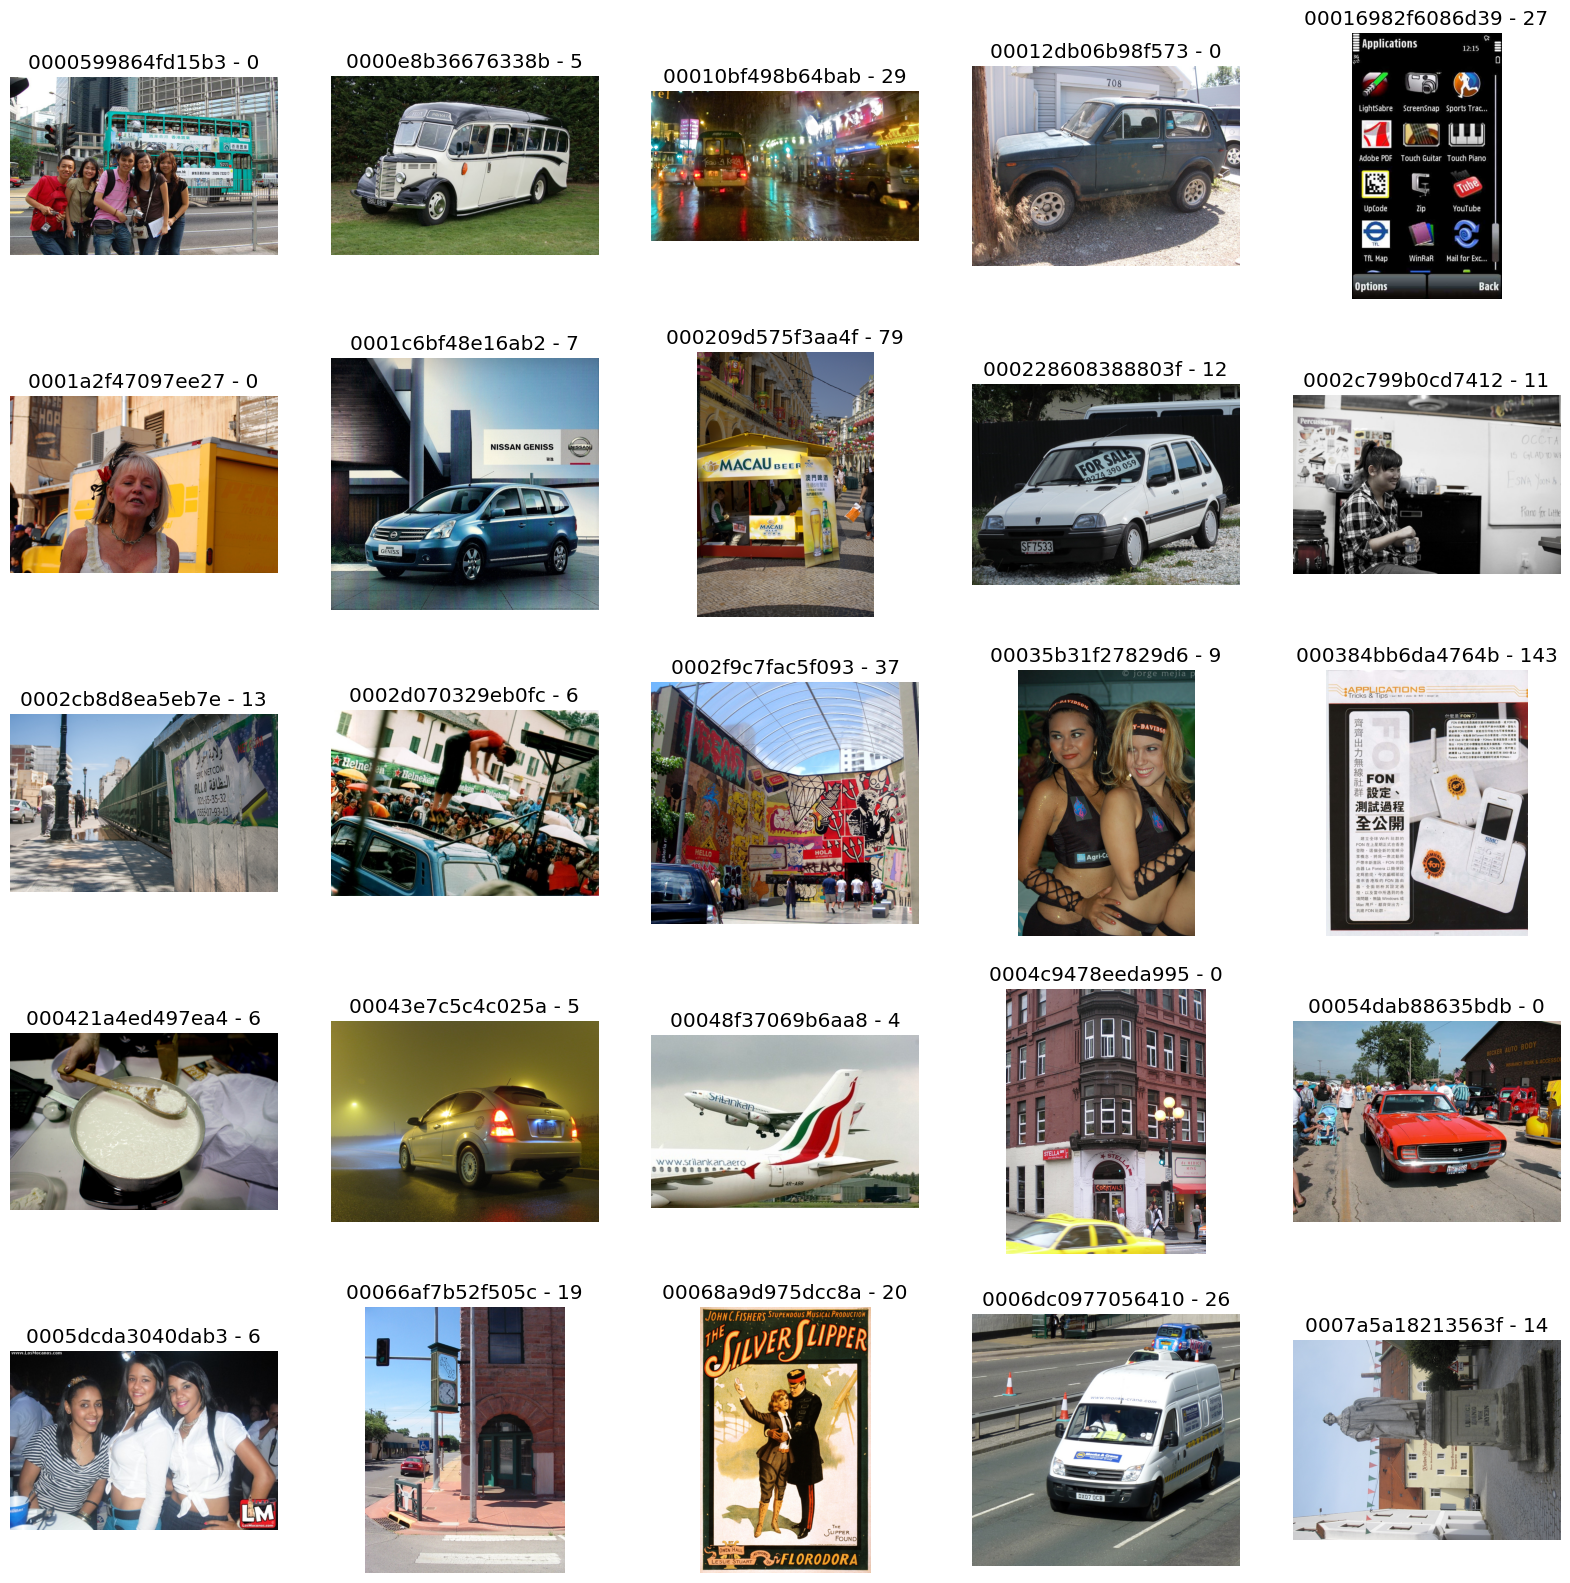

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(plt.imread(img_fns[i]))
    axs[i].axis('off')
    image_id = img_fns[i].split('/')[-1].split('\\')[-1].split('.')[0]
    n_annot = len(annot.query('image_id == @image_id'))
    axs[i].set_title(f'{image_id} - {n_annot}')
plt.show()

***

# Comparison method:
Because the bounding box can be slightly different depending on the OCR engine, it would not be possible to to let the engines detect text, and compare the result to the ground truth by comparing it with the text in the bounding boxes provided by the dataset. Since words can repeat in a single picture, looking if a string is included in the annotations could also lead to false positives. 
To avoid these problems, the bounding boxes described by the dataset for the text will be used by the OCR engines as Regions Of Interet (ROIs). The resulting detected string can then be compared one-to-one to the base truth for this area of the picture.
Working on ROIs rather than the whole picture can improve the accuracy of the detection and recognition of characters by reducing noise, leading to skewed comparison results, but since the use cases of this thesis will also make use of ROIs, this method is here appropriate to choose the best engine for our uses.

### Statistical tests:
Test on 100 randomly chosen pictures from dataset
1. Word accuracy
2. Character accuracy -> Levenshtein distance
<br>-> Remove punctuation?

In [8]:
sample_size = 100
sample_idxs = random.sample(range(0, len(img_fns)), sample_size)

class Img:
    def __init__(self, idx):
        self.image = cv2.imread(img_fns[idx])
        self.image_id = img_fns[idx].split('/')[-1].split('\\')[-1].split('.')[0]
        self.annotations = annot.query('image_id == @self.image_id')

sample = [Img(idx) for idx in sample_idxs]


In [9]:
sample[0].annotations

,id,image_id,bbox,utf8_string,points,area


# Method 1: pytesseract

In [10]:
from pytesseract import pytesseract
pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

In [12]:
total_accurate = 0
total_annot = 0

for img in sample[:20]:

    with open('pytesseract_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write(f"Image {img.image_id}:\n")

    img_accurate = 0
    img_annot = len(img.annotations)
    total_annot += img_annot

    for _, row in img.annotations.iterrows():
        
        roi = [int(x) for x in row['bbox']]
        roi_img = img.image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
        result = pytesseract.image_to_string(roi_img)
        
        if result.lower() == row['utf8_string'].lower():
            total_accurate += 1
            img_accurate += 1

        with open('pytesseract_accuracy_test.txt', 'a', encoding="utf-8") as f:
            f.write(f"Expected: {row['utf8_string'].lower()}, actual: {result.lower()}\n")

    with open('pytesseract_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write("\n")
    
    print(f"Image word accuracy = {img_accurate}/{img_annot}")

Image word accuracy = 0/0
Image word accuracy = 0/34
Image word accuracy = 0/7
Image word accuracy = 0/19
Image word accuracy = 0/11
Image word accuracy = 0/0
Image word accuracy = 0/20
Image word accuracy = 0/8
Image word accuracy = 0/0
Image word accuracy = 0/93
Image word accuracy = 0/34
Image word accuracy = 0/18
Image word accuracy = 0/18
Image word accuracy = 0/1
Image word accuracy = 0/79
Image word accuracy = 0/0
Image word accuracy = 0/8
Image word accuracy = 0/31
Image word accuracy = 0/50
Image word accuracy = 0/22


In [13]:
print(f"Total word accuracy = {total_accurate}/{total_annot}")   

Total word accuracy = 0/453


# Method 2: easyocr

In [14]:
import easyocr
reader = easyocr.Reader(['en'], gpu = True)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [27]:
total_accurate = 0
total_annot = 0

for img in sample[:20]:

    with open('easy_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write(f"Image {img.image_id}:\n")

    img_accurate = 0
    img_annot = len(img.annotations)
    total_annot += img_annot

    for _, row in img.annotations.iterrows():
        
        roi = [int(x) for x in row['bbox']]
        roi_img = img.image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
        result = reader.readtext(roi_img)
        result_df = pd.DataFrame(result, columns=['bbox','text','conf'])
        result = ''.join(result_df['text'])
        
        if result.lower() == row['utf8_string'].lower():
            total_accurate += 1
            img_accurate += 1
        else:
            with open('easy_accuracy_test.txt', 'a', encoding="utf-8") as f:
                f.write(f"Expected: {row['utf8_string'].lower()}, actual: {result.lower()}\n")

    with open('easy_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write("\n1")
    
    print(f"Image word accuracy = {img_accurate}/{img_annot}")

Image word accuracy = 0/0
Image word accuracy = 6/34
Image word accuracy = 0/7
Image word accuracy = 1/19
Image word accuracy = 3/11
Image word accuracy = 0/0
Image word accuracy = 8/20
Image word accuracy = 1/8
Image word accuracy = 0/0
Image word accuracy = 8/93
Image word accuracy = 8/34
Image word accuracy = 1/18
Image word accuracy = 10/18
Image word accuracy = 0/1
Image word accuracy = 0/79
Image word accuracy = 0/0
Image word accuracy = 1/8
Image word accuracy = 2/31
Image word accuracy = 0/50
Image word accuracy = 1/22


# Method 3: keras_ocr

In [ ]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

In [ ]:
results = pipeline.recognize([img_fns[100]])

In [ ]:
pd.DataFrame(results[0], columns=['text', 'bbox'])